# Topic Model

In [8]:
# lanciare nel caso in cui non sia stato ancora effettuato il download delle stopwords di nltk
#import nltk; nltk.download('stopwords'); nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paolo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

#### Importiamo le librerie

In [1]:
import os
import re
import numpy as np
import pandas as pd
import string
from pprint import pprint
import time

import nltk
from collections import Counter
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import WordPunctTokenizer

from imblearn.under_sampling import RandomUnderSampler

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim  
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'got', 'get', 'dont'])
lemmatizer = WordNetLemmatizer() 

#### Caricamento dei dati

In [2]:
df = pd.read_csv('final.csv', sep=',')
df.head

<bound method NDFrame.head of                                               filmScript  Genres  target
0                              That was incredible. H...   Drama       0
1                              1 Street justice, punk...   Drama       0
2                              Big Al has a huge cock...   Drama       0
3                              1 (ominous music) (fro...   Drama       0
4                              [soft rumbling] [spark...   Drama       0
...                                                  ...     ...     ...
14117                          1 I'm sorry Are you fr...  Action       4
14118                          ( machine clanking ) (...  Action       4
14119                          1 Run! Monster! Help! ...  Action       4
14120                          Wrong number! Come on....  Action       4
14121                          The Secretary of State...  Action       4

[14122 rows x 3 columns]>

Per coerenza rispetto alle altre applicazioni del progetto, viene effettuato anche in questo caso l'under sampling.

In [3]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

rus = RandomUnderSampler(replacement=False, random_state=1234)
X, y= rus.fit_sample(X, y)
y.value_counts()

3    1246
2    1246
1    1246
4    1246
0    1246
Name: target, dtype: int64

#### Pre-Processing

Viene definito il preprocessing in cui vengono effettuate le seguenti operazioni:
- Vengono eliminati i numeri;
- Viene eliminato quello che si trova dentro le quadre (sottotitoli);
- Vengono eliminati punteggiature e caps lock;
- Tokenizzazione: processo mediante il quale le frasi vengono convertite in un elenco di token o parole;
- Vengono eliminate le stopwords;
- Lemmatizzazione: riduce le forme flessive di ogni parola in una base o radice comune.

In [4]:
def preprocText(text):
    text = re.sub(r'\d', '', text)
    text = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)
    text = text.translate(str.maketrans('','',string.punctuation)).lower()
    tokenized_text = WordPunctTokenizer().tokenize(text)

    ##REMOVING STOPWORDS
    tokenized_text_without_stopwords = []
    for token in tokenized_text:
        if token not in stop_words:
            token = lemmatizer.lemmatize(token)
            if(len(token)) > 2:
                tokenized_text_without_stopwords.append(token)
        
    return tokenized_text_without_stopwords

In [5]:
n = len(X)
corp = [preprocText(item) for item in X.filmScript]

#### LDA Model

Vengono creati i vari elementi per la costruzione del modello Latent Dirichlet Allocation.

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(corp)

# Create Corpus
texts = corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [8]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [9]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"people" + 0.006*"time" + 0.005*"one" + 0.005*"would" + 0.004*"need" '
  '+ 0.004*"president" + 0.004*"sir" + 0.004*"work" + 0.004*"world" + '
  '0.004*"case"'),
 (1,
  '0.018*"sir" + 0.016*"let" + 0.016*"come" + 0.012*"back" + 0.011*"right" + '
  '0.010*"move" + 0.010*"one" + 0.009*"take" + 0.006*"kill" + 0.006*"way"'),
 (2,
  '0.034*"gonna" + 0.030*"man" + 0.022*"aint" + 0.021*"right" + 0.018*"come" + '
  '0.018*"hey" + 0.015*"yeah" + 0.015*"boy" + 0.011*"gotta" + 0.009*"baby"'),
 (3,
  '0.110*"lts" + 0.089*"lll" + 0.044*"lve" + 0.026*"game" + 0.026*"bobby" + '
  '0.025*"team" + 0.023*"ray" + 0.015*"win" + 0.014*"ball" + 0.013*"race"'),
 (4,
  '0.025*"yeah" + 0.023*"okay" + 0.023*"know" + 0.017*"like" + 0.016*"right" + '
  '0.014*"hey" + 0.014*"youre" + 0.013*"gonna" + 0.011*"thats" + 0.010*"come"'),
 (5,
  '0.027*"sir" + 0.023*"come" + 0.010*"hey" + 0.010*"let" + 0.009*"brother" + '
  '0.009*"take" + 0.009*"like" + 0.008*"yes" + 0.008*"one" + 0.008*"tell"'),
 (6,
  '0.

Vengono calcolati alcuni indicatori di performance quali la perplessità del modello e la coerenza dell'argomento, che forniscono una misura conveniente per giudicare quanto sia buono un determinato modello.

In [48]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corp, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.4765261131487

Coherence Score:  0.3988799172278974


La coerenza del modello sembra essere buona, quasi sul 40%.

Vengono visualizzati i topic con la libreria pyLDAvis.

In [42]:
# Visualize the topics
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [49]:
pyLDAvis.save_html(vis, 'lda.html')

#### Word Cloud

Wordcloud è un ottimo modo per rappresentare i dati di testo. La dimensione e il colore di ogni parola che appare nel wordcloud indicano la sua frequenza o importanza.

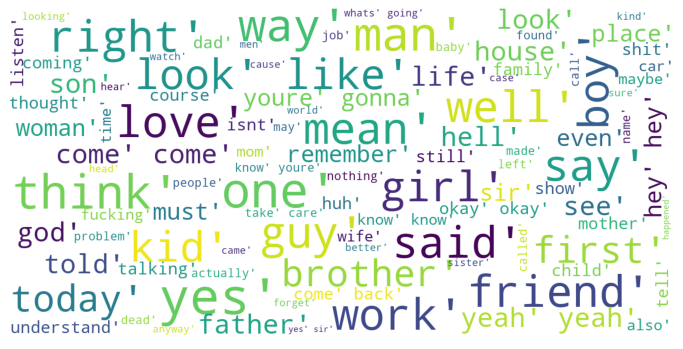

In [35]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(texts)

Come possiamo vedere, le parole più rilevanti nei copioni sono quelle tipiche nelle conversazioni come sostantivi legati ad affermazioni.

Visualizziamo ora il Wordcloud delle N parole più citate in ogni topic.

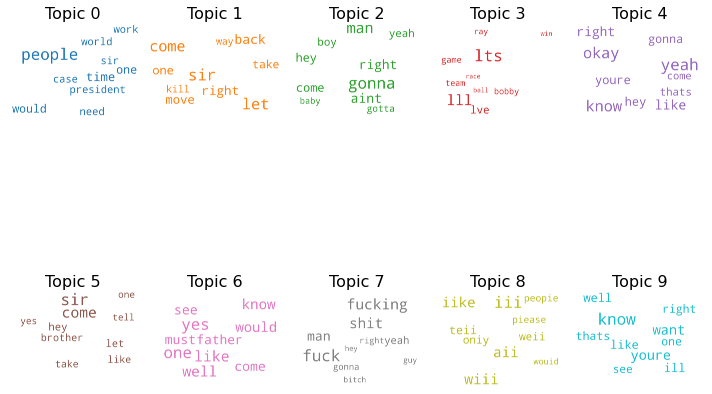

In [46]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()